# **PRE PROCESSING**

Import required libraries

In [4]:
!pip install spacy
import spacy
import pandas as pd
import re

Download and load spaCy English model

In [5]:
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 41.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load dataset (Text Headlines)

In [7]:
df_text = pd.read_csv("/content/drive/MyDrive/FDS/stock_data.csv")
print("Sample data:\n", df_text.head())

Sample data:
                                                 Text Sentiment
0  SAM cheers to the temporary solution to our ec...  positive
1                                    SK to the GAVE!  negative
2  One of the other reviewers has mentioned that ...  positive
3  A wonderful little production. <br /><br />The...  positive
4  I thought this was a wonderful way to spend ti...  positive


 Preprocessing function using spaCy

In [8]:
def clean_text_spacy(text):
    if not isinstance(text, str):   # handle NaN or non-string
        return ""
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)   # remove HTML tags
    text = re.sub(r'[^a-z\s]', '', text)  # keep only letters and spaces
    doc = nlp(text)
    # remove stopwords + lemmatize
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return " ".join(tokens)


Apply preprocessing

In [9]:
df_text['cleaned_text'] = df_text['Text'].apply(clean_text_spacy)

Encode sentiment labels (positive=1, negative=0)

In [10]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df_text['sentiment_encoded'] = encoder.fit_transform(df_text['Sentiment'])

 Preview cleaned data

In [11]:
print("After preprocessing:\n", df_text[['Text','cleaned_text','Sentiment','sentiment_encoded']].head())


After preprocessing:
                                                 Text  \
0  SAM cheers to the temporary solution to our ec...   
1                                    SK to the GAVE!   
2  One of the other reviewers has mentioned that ...   
3  A wonderful little production. <br /><br />The...   
4  I thought this was a wonderful way to spend ti...   

                                        cleaned_text Sentiment  \
0  sam cheer temporary solution economic woe   en...  positive   
1                                            sk gave  negative   
2  reviewer mention watch   oz episode ll hook ri...  positive   
3  wonderful little production filming technique ...  positive   
4  think wonderful way spend time hot summer week...  positive   

   sentiment_encoded  
0                  1  
1                  0  
2                  1  
3                  1  
4                  1  


Save for later use

In [12]:
df_text.to_csv("cleaned_headlines.csv", index=False)
print("Preprocessed text saved as cleaned_headlines.csv")

Preprocessed text saved as cleaned_headlines.csv


# **EDA**

Import libraries

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter


Load preprocessed dataset

In [14]:
df_text = pd.read_csv("cleaned_headlines.csv")
print("Dataset shape:", df_text.shape)
print("Columns:", df_text.columns)
print(df_text.head())


Dataset shape: (51948, 4)
Columns: Index(['Text', 'Sentiment', 'cleaned_text', 'sentiment_encoded'], dtype='object')
                                                Text Sentiment  \
0  SAM cheers to the temporary solution to our ec...  positive   
1                                    SK to the GAVE!  negative   
2  One of the other reviewers has mentioned that ...  positive   
3  A wonderful little production. <br /><br />The...  positive   
4  I thought this was a wonderful way to spend ti...  positive   

                                        cleaned_text  sentiment_encoded  
0  sam cheer temporary solution economic woe   en...                  1  
1                                            sk gave                  0  
2  reviewer mention watch   oz episode ll hook ri...                  1  
3  wonderful little production filming technique ...                  1  
4  think wonderful way spend time hot summer week...                  1  


Check basic info

In [15]:
print("Data info:")
print(df_text.info())

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51948 entries, 0 to 51947
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Text               51948 non-null  object
 1   Sentiment          51948 non-null  object
 2   cleaned_text       51948 non-null  object
 3   sentiment_encoded  51948 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.6+ MB
None


 Check missing values

In [16]:
print("Missing values:\n", df_text.isnull().sum())

Missing values:
 Text                 0
Sentiment            0
cleaned_text         0
sentiment_encoded    0
dtype: int64


Sentiment distribution

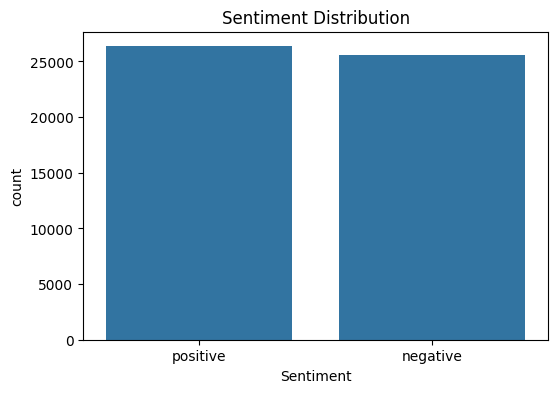

In [17]:
plt.figure(figsize=(6,4))
sns.countplot(x='Sentiment', data=df_text)
plt.title("Sentiment Distribution")
plt.show()


Length of headlines (original)

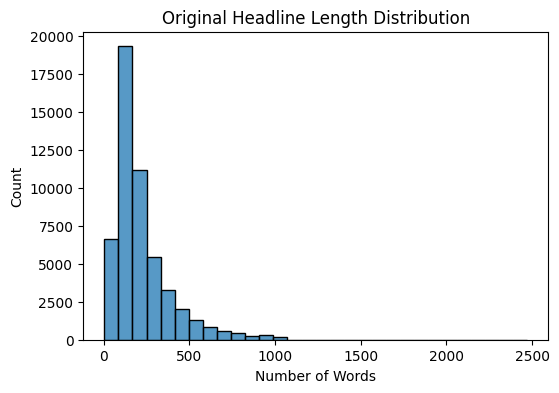

In [18]:
df_text['text_length'] = df_text['Text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(6,4))
sns.histplot(df_text['text_length'], bins=30)
plt.title("Original Headline Length Distribution")
plt.xlabel("Number of Words")
plt.show()

Length of cleaned headlines

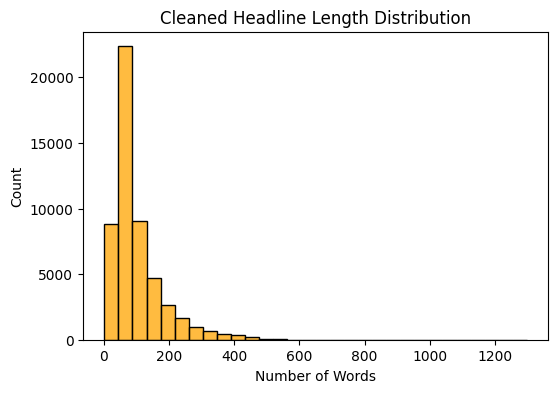

In [19]:
df_text['cleaned_length'] = df_text['cleaned_text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(6,4))
sns.histplot(df_text['cleaned_length'], bins=30, color='orange')
plt.title("Cleaned Headline Length Distribution")
plt.xlabel("Number of Words")
plt.show()

Most frequent words (cleaned text)

In [20]:
all_words = ' '.join(df_text['cleaned_text']).split()
word_freq = Counter(all_words)
most_common = word_freq.most_common(20)
print("Top 20 most frequent words:", most_common)

Top 20 most frequent words: [('movie', 99014), ('film', 91609), ('not', 67024), ('like', 42847), ('good', 39601), ('s', 33074), ('time', 29443), ('character', 27566), ('watch', 27037), ('bad', 25516), ('see', 24427), ('story', 24194), ('think', 22803), ('scene', 20704), ('great', 19649), ('look', 19052), ('know', 18551), ('people', 18010), ('go', 17685), ('get', 17173)]


Wordcloud for cleaned text

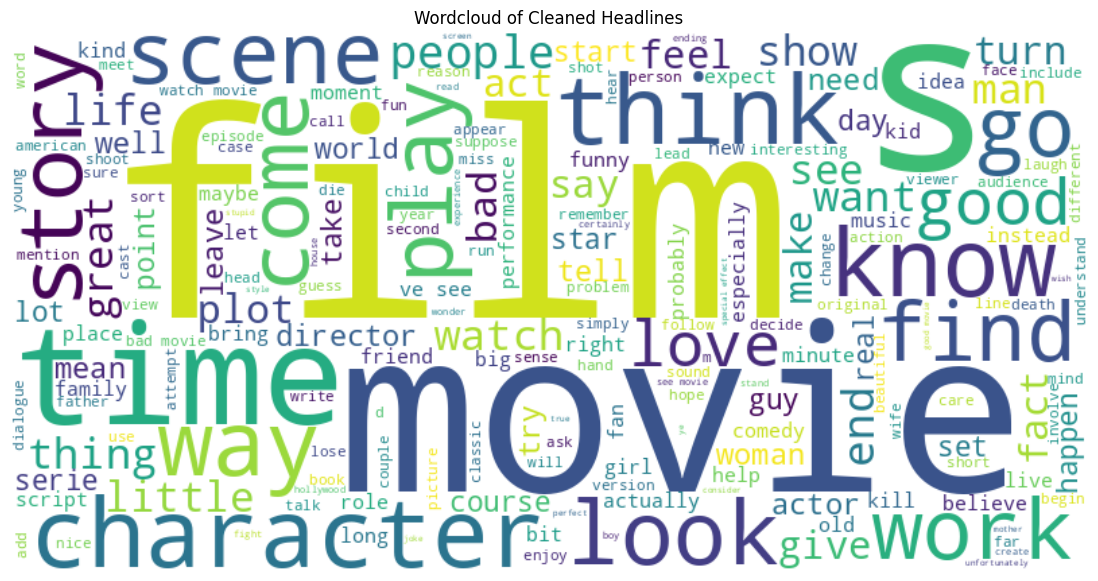

In [21]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_text['cleaned_text']))
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Wordcloud of Cleaned Headlines")
plt.show()


Sentiment-wise top words

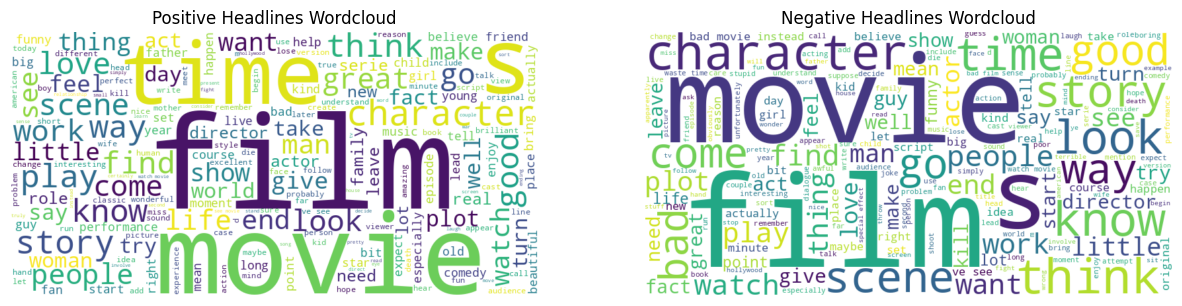

In [22]:
positive_text = ' '.join(df_text[df_text['Sentiment']=='positive']['cleaned_text'])
negative_text = ' '.join(df_text[df_text['Sentiment']=='negative']['cleaned_text'])

pos_wc = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
neg_wc = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.imshow(pos_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Headlines Wordcloud")

plt.subplot(1,2,2)
plt.imshow(neg_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Headlines Wordcloud")
plt.show()